분류 실습 - 캐글 산탄데로 고객 만족 예측
-----------------------------------------
- 고객의 만족 여부 예측
- 클래스 레이블 이름 : Target
  - 0 : 만족한 고객 / 1 : 불만 가진 고객
- 모델 성능 평가 : ROC-AUC (ROC 곡선 영역)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df=pd.read_csv('/content/sample_data/train.csv', encoding='latin-1')  # 'latin1'방식으로 인코딩 돼있으니깐 글짜 안 깨지게 적음 
print('dataset shape:', cust_df.shape)
cust_df.head()

In [ ]:
cust_df.info()

In [ ]:
print(cust_df['TARGET'].value_counts())

In [ ]:
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은{0:.2f}'.format((unsatisfied_cnt/total_cnt)))

In [ ]:
cust_df.describe()

- nan, 예외 값을 -999999로 변환했음을 추정할 수 있음
- 다른 값에 비해 편차 높음


- 가장 많은 2로 변환
- id 피처는 단순 식별자니깐 피처 드롭 해주기

In [ ]:
#var3은 숫자형이고, 다른 값에 비해 -999999는 편차가 너무 심하므로 가장 값이 많은 2로 변환

cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

#피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

비대칭한 데이터 세트
  - -> target 값 분포도가 train, test 세트에 모두 비슷하게 추출됐는지 확인하기

In [ ]:
# 학습 데이터 세트와 테스트 데이터 세트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))
print(' **학습 세트 레이블 값 분포 비율**')
print(y_train.value_counts()/train_cnt)

print('\n **테스트 세트 레이블 값 분포 비율**')
print(y_test.value_counts()/test_cnt)

- roc-auc가 약 0.8413

XGBoosting의 하이퍼 파라미터 튜닝
---------------------------------------
예측 결과를 ROC AUC로 평가해보자.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

- roc-auc가 약 0.8451
> 이전 예제에서의 0.8413보다 조금 개선됨을 알 수 있음

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

- roc-auc가 -.8460으로 이전 결과보다 살짝 향상됨
- BUT ... GBM을 기반하고 있기 때문에 수행시간이 긺

In [ ]:
# 피쳐 중요도 그래프로 나타내기
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax , max_num_features=20, height=0.4)

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처 : var38, var15 ...

LightBGM 모델 학습과 하이퍼 파라미터 튜닝
------------------------------------------
예측 성능을 ROC-AUC로 측정해보자.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

- LightGBM 수행 결과 ROC-AUC가 0.8409 (XGBoost보다 학습 시간 단축)

GridSearchCV로 하이퍼 파라미터 튜닝해보자.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64],'max_depth':[128,160],'min_child_samples':[60,100],'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
# 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과 도출
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

분류 실습 - 캐글 신용카드 사기 검출
---------------------------------------
레이블이 불균형한 분포인 데이터 세트 : 학습 시 예측 성능 문제 발생
- 적절한 학습 데이터 확보 방안 필요
- 오버 샘플링 / 언더 샘플링 필요 !

언더 샘플링
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 단점 : 정상 레이블의 경우, 오히려 제대로 된 학습 수행을 할 수 없음
- 잘 적용하지는 않는 방법

오버 샘플링
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 원본 데이터의 피처 값들을 아주 약간씩만 변경해서 증식
- 대표적 방법 : SMOTE 방법
  - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식
  - imbalanced-learn

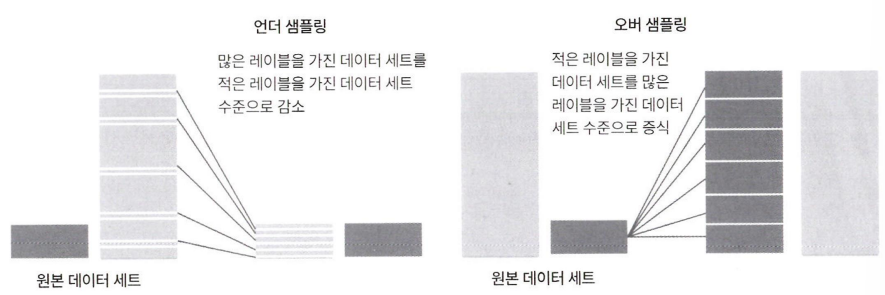

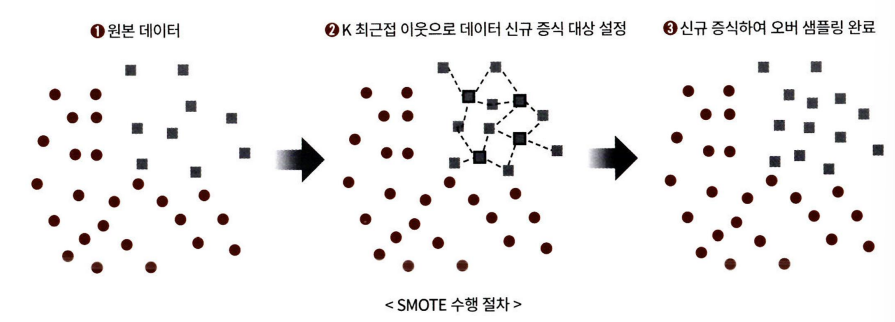

데이터 일차 가공 + 모델 학습/평가/예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/sample_data/creditcard.csv')
card_df.head(3)

- time 피처 안 중요하니깐 드롭해주기
- amount 피처 : 신용카드 거래 금액
- class : 레이블   /   0 : 정상 , 1 : 사기거래

In [ ]:
card_df.info()
# 전체 284,807개의 레코드에서 결측치(Missing Value) 값은 없음

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

- 학습 데이터와 테스트 데이터의 레이블이 각각 0.172% , 0.173%로 비슷함

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 이용해 신용 카드 사기 여부 예측
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 예측 성능 평가
get_clf_eval(y_test, lr_pred, lr_pred_proba)

테스트 데이터로 측정 시 재현율 (recall)이 0.5946, roc-auc가 0.9593

In [ ]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

데이터 분포도 변환 후 모델 학습/예측/평가
- 로지스틱 회귀 : 선형 모델 -> 중요 피처값이 정규 분포 형태를 유지하는 것을 선호

In [ ]:
# Amount 피처의 분포도 확인
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM과 로지스틱 회귀, 두 모델 모두 변환 후 성능이 크게 개선되지는 않음

In [ ]:
# 로그 변환 수행
# 로그 변환 - 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

이상치 데이터 제거 후 모델 학습/예측/평가
- IQR(Inter Quantile Range) : 이상치 찾는 방법 중 하나
  - IQR에 1.5 곱해서 생성된 범위를 이용해 최댓값고 최솟값 결정 + 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주
  - 최댓값 : Q3 + IQR*1.5
  - 최솟값 : Q1 - IQR*1.5

In [ ]:
# 각 피처별로 상관계수 구한 뒤 heatmap 이용해서 시각화하기
# cmap = 'RdBu' : 양(음)의 상관관계 높을수록 색깔 진한 파랑(빨강)

import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
#IQR 이용해 이상치 검출하는 함수 생성 후 이상치 삭제 
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
# V14에 대해 IQR 이상치 찾아서 제
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

- 이상치 제거 후 로지스틱 회귀, LightGBM 모두 예측 성능 크게 향상됨

SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 후 데이터 증식됨

In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

- 오버 샘플링된 데이터로 학습하면 ...
  - 재현율 크게 증가 / 정밀도 크게 감소

In [ ]:
# precision_recall_curve_plot() :
# SMOTE로 학습된 로지스틱 회귀 모델에 어떤 문제가 발생하고 있는지 시각화하는 함수

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1])

- 로지스틱 회귀에서는 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함

LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

- 이상치만 제거한 경우보다 재현율 상승
- 정밀도 감소

  -> SMOTE 적용하면 재현율 상승 / 정밀도 감소

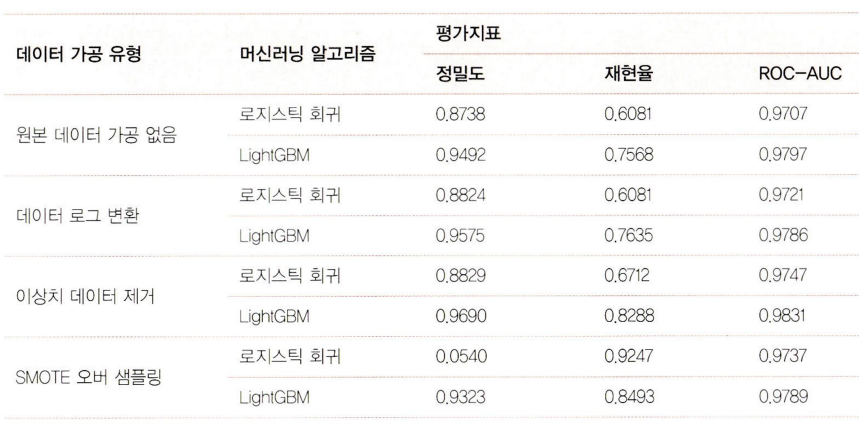